<a href="https://colab.research.google.com/github/peremartra/Tailoring-LLM-Architectures/blob/main/CH05/CH05_NB01_width_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tailoring LLM Architectures
## Surgical Optimization Beyond Fine-Tuning


### Chapter 5: width pruning
### Notebook: 01. Static Neuron Selection.
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

_____
Colab Environment: GPU T4

Models:
* Llama-3.2-1B
_____

In this notebook, we explore width pruning applied to the  MLP modules with GLU structure, present in modern Transformers models like Llama, Gemma, Qwen, Mistral and more.  

We'll implement a static neuron selection method that ranks neurons by their weight magnitude. The underlying hypothesis is simple: neurons whose weights have smaller absolute values contribute less to the model's transformations, making them candidates for removal with minimal impact on performance.

By the end of this notebook, you'll understand how to surgically reduce the expansion ratio of an MLP module—going from 4x to 2.4x in our Llama-3.2-1B example—and measure the trade-offs this creates.

```
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
```


# Setting up notebook

In [1]:
!pip install -q \
      "torch" \
      "transformers==4.55.4" \
      "accelerate==1.10.1" \
      "lm_eval==0.4.9.1" \
      "sentencepiece==0.2.1" \
      "sentence-transformers==5.1.0" \
      "langdetect" \
      "codecarbon" \
      "optipfair==0.2.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 58.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.4/483.4 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.6/357.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from lm_eval import evaluator
from torch import nn
from lm_eval.models.huggingface import HFLM
import os
import json
import copy
from optipfair import prune_model

In [3]:
MAX_NEW_TOKENS = 50
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


The helper functions used in previous notebooks have been grouped in the [`utils.py`](https://github.com/peremartra/llama-glu-expansion-pruning/blob/main/utils.py) file. To use them, we import the file from the repository.

In [4]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
  model_evaluation, # Evals with lm_eval
  evaluate_metrics, # Loss & Perpelexity
  generate_text, #test inference model
  clear_gpu_cache
)

✅ utils.py downloaded successfully


# 5.1 Static neuron selection.

For this experiment, we'll use Llama-3.2-1B—a compact but capable model that makes our pruning effects clearly visible. This model has a hidden size of 2048 and an intermediate size of 8192, giving it a 4x expansion ratio in its MLP modules. That 4x expansion is exactly what we're about to surgically reduce.

Remember from Chapter 3: in GLU-based architectures like Llama, the MLP module expands the representation from hidden_size to intermediate_size, processes it through gating mechanisms, and contracts it back.

By targeting this expansion, we can shrink the model without breaking the connections between modules—the attention layer will still receive tensors of size 2048, just as it expects.

## Load Model


In [ ]:
MODEL_NAME = 'meta-llama/Llama-3.2-1B'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()
model.generation_config.temperature = None
model.generation_config.top_p = None
model.generation_config.top_k = None

In [6]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [7]:
# Test the original model
prompt = "Paris is the capital of"
generated = generate_text(model, tokenizer, prompt, device)
print(f"Generated text: {generated}")

Generated text: Paris is the capital of France and the largest city in the country. It is located on the River Seine and is one of the most popular tourist destinations in Europe. The city has a rich history and culture, and it is home to many famous landmarks, including the E


## 5.1.1 Choosing neurons to discard

As we already saw in [chapter 3](https://github.com/peremartra/Rearchitecting-LLMs/tree/main/CH03), we find a set of three layers in the MLP module.
* `gate_proj` and `up_proj` scale the information from 2048 to 8192 and `down_proj` returns it to 2048, its original size.

Our width pruning method directly attacks this expansion.
This allows us to vary the size of the different layers individually without breaking the model, the connection between the MLP layer and the Attention layer will always be with the original length of the data. In the case of Llama-3.2-1B 2048.

The `compute_neuron_pair_importance` function calculates an importance score for each neuron by analyzing its weights across both `gate_proj` and `up_proj` layers. Why look at both? Because in GLU architectures, these two projections work as a pair—one gates the other—so a neuron's true contribution depends on its combined weight magnitude across both transformations.

The function computes the maximum absolute weight range for each neuron in both layers, then sums these values to produce a single importance score per neuron. Neurons with higher scores have larger weight magnitudes and are presumed to contribute more to the model's transformations, making them safer to keep.


In [8]:
def compute_neuron_pair_importance(gate_weight, up_weight):
  """
  compute neuron pair importance scores (Maximum Absolute Weight)

  Args:
  - gate_weight: Weight matrix from the gate_proj layer.
  - up_weight: Weight matrix from the up_weight layer.

  Returns:
  - importance_scores: Importance scores for each neuron pair.
  """

  gate_max_abs = torch.max(gate_weight, dim=1).values + torch.abs(torch.min(gate_weight, dim=1).values)
  up_max_abs = torch.max(up_weight, dim=1).values + torch.abs(torch.min(up_weight, dim=1).values)
  importance_scores = gate_max_abs + up_max_abs
  return importance_scores

Now that we can measure neuron importance, we need a function that actually performs the surgery. `prune_neuron_pairs` takes our importance scores, ranks all neurons, and keeps only the top performers based on our pruning percentage.



## 5.1.2 Reconstructing the MLP module

The process is straightforward: calculate how many neurons to keep, identify their indices, create new smaller layers with the reduced dimensions, and copy over only the weights that correspond to our selected neurons. The result? Three new layers: `gate_proj`, `up_proj`, and `down_proj`, that are narrower but still perfectly compatible with the rest of the model.

In [9]:
def prune_neuron_pairs(mlp, prune_percent):
    """
    Reduces the dimensions of the **gate_proj**,**up_proj**, **down_proj**
    layers removing the least important neurons.

    Args:
    - mlp: Layers to prune.
    - prune_percent: Percentage of neurons to prune.

    Returns:
    - new_gate_proj, new_up_proj, new_down_proj:  New pruned layers.
    - k: New intermediate size.

    """
    # Extract the weights from the MLP layers
    #  these weights are used to calculate each neuron's
    #  importance score in the next step.
    gate_weight = mlp.gate_proj.weight.data.float()
    up_weight = mlp.up_proj.weight.data.float()

    #Compute importance stores. Neurons with higher importance scores
    # are considered more important and less likely to be pruned.
    importance_scores = compute_neuron_pair_importance(gate_weight, up_weight)

    #Store the original number of neurons in the intermediate layer.
    original_intermediate_size = gate_weight.size(0)
    #Computes the number of neurons to prune.
    neurons_to_prune = min(int(prune_percent * original_intermediate_size), original_intermediate_size - 1)
    #Calculate the number of neurons to keep. The new intermediate size.
    k = original_intermediate_size - neurons_to_prune

    #Just check that there is no big error calculating k. We can't prune all the neurons.
    if k <= 0:
        raise ValueError(f"Invalid number of neuron pairs to keep: {k}. Adjust the prune_percent.")

    #Select the neuros to keep, by obtaining the indices to keep.
    _, indices_to_keep = torch.topk(importance_scores,
                                    k,
                                    largest=True,
                                    sorted=True)
    indices_to_keep = indices_to_keep.sort().values

    #create the new layers
    new_gate_proj = nn.Linear(mlp.gate_proj.in_features, k, bias=False).to(device)
    new_up_proj = nn.Linear(mlp.up_proj.in_features, k, bias=False).to(device)
    new_down_proj = nn.Linear(k, mlp.down_proj.out_features, bias=False).to(device)

    #copy weights to the new layers.
    new_gate_proj.weight.data = mlp.gate_proj.weight.data[indices_to_keep, :]
    new_up_proj.weight.data = mlp.up_proj.weight.data[indices_to_keep, :]
    new_down_proj.weight.data = mlp.down_proj.weight.data[:, indices_to_keep]

    #return new layers and intermediate size.
    return new_gate_proj, new_up_proj, new_down_proj, k


## 5.1.3 Implementing the pruning workflow

Now we need to scale this operation across the entire model. The `update_model` function orchestrates the pruning by walking through each of the model's transformer blocks, applying `prune_neuron_pairs` to every MLP module, and swapping in the newly pruned layers.

Crucially, it also updates the model's configuration file to reflect the new `intermediate_size`. Without this step, any code that inspects the model's architecture would still see the old dimensions—a recipe for confusion later.

When this function finishes, we'll have a fully functional model that's structurally identical to the original, just narrower in MLP Layers.




In [10]:
#Iterates throught the model layers and applies pruning.
def update_model(model, prune_percent):
    """
    It modifies each mlp layer present in model, to retain only the most
    important neurons. Creating new smaller versions of each layer pruned.

    Args:
    - model: Model to prune.
    - prune_percent: Percentage of neurons to prune.

    Returns:
    - model: New pruned model.
    """
    new_intermediate_size = None

    #loop for each model layer.
    for idx, layer in enumerate(model.model.layers):
        #Since each layer is a LlamaDecoderLayer it contains multiple components
        # Attention, MLP and Layer norms. We're targetting MLP component
        # by accesing layer.mlp.
        mlp = layer.mlp

        #Call the prune_neiron_pairs with the layers and receiving the pruned.
        new_gate_proj, new_up_proj, new_down_proj, new_size = prune_neuron_pairs(mlp, prune_percent)

        #Replace the Origiginal Layers with Pruned Layers.
        mlp.gate_proj = new_gate_proj
        mlp.up_proj = new_up_proj
        mlp.down_proj = new_down_proj

        #new_intermediate_size only needs to be set once
        new_intermediate_size = new_size

    #Update the model config file.
    model.config.intermediate_size = new_intermediate_size

    return model


We'll prune 40% of the expansion neurons from every MLP module, shrinking the expansion ratio from 4x down to roughly 2.4x. This single change will reduce the model's total parameter count by over 26%.


In [11]:
prune_percent = 0.4  # Prune 40% of neurons
model_pruned = update_model(copy.deepcopy(model), prune_percent)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [13]:
# Recalculate the number of parameters
original_param_count = count_parameters(model)
pruned_param_count = count_parameters(model_pruned)
reduction_in_params = original_param_count - pruned_param_count
percentage_savings = (reduction_in_params / original_param_count) * 100

print(f"Pruned model parameters: {pruned_param_count}")
print(f"Reduction in parameters: {reduction_in_params}")
print(f"Percentage of weight savings: {percentage_savings:.2f}%")

Pruned model parameters: 913770496
Reduction in parameters: 322043904
Percentage of weight savings: 26.06%


In [14]:
print(model_pruned)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=4916, bias=False)
          (up_proj): Linear(in_features=2048, out_features=4916, bias=False)
          (down_proj): Linear(in_features=4916, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

We can see that now the intermediate_size is 4916, so the expansion has gone from 4x to 2.4x

## 5.1.4 Measuring the impact: benchmarks and trade-off

In [15]:
# Test the pruned model
generated = generate_text(model_pruned, tokenizer, prompt, device)
print(f"Generated text after pruning: {generated}")

Generated text after pruning: Paris is the capital of France. It is also known as Paris, the city of the France, is located in the center of this country. Paris is a capital city, it is known also as the Paris city. This city is one of Europe's most famous cities.


The model still generates fluent text, but the output has clearly shifted. Compare the two responses: the original gives us a clean, factual statement ("Paris is the capital of France and the largest city in the country"), while the pruned version becomes repetitive and awkward ("Paris, the city of the France").

The sentence structure degrades, coherence drops—but critically, the model hasn't collapsed into gibberish.

In [16]:
del(model)
clear_gpu_cache()

In [17]:
BENCHMARKS_PRUNED = [
    {"name": "truthfulqa_mc2", "num_fewshot": 0},
    {"name": "lambada_openai", "num_fewshot": 0},
    {"name": "lambada_standard", "num_fewshot": 0},
    #{"name": "wikitext", "num_fewshot": 0},
    #{"name": "mmlu", "num_fewshot": 5},  # Standard is 5-shot for MMLU
    #{"name": "gsm8k", "num_fewshot": 5},  # Chain-of-thought requires few-shot
    #{"name": "ifeval", "num_fewshot": 0},
    #{"name": "leaderboard_musr", "num_fewshot": 0}, # Removed this task as it seems to be causing issues
]

In [ ]:
results_pruned = model_evaluation(model_pruned,
                                  tokenizer,
                                  BENCHMARKS_PRUNED,
                                  limit=100,
                                  batch_size=4)

In [19]:
results_pruned

{'lambada_openai': {'perplexity': '110.85',
  'word_perplexity': '0.00',
  'bits_per_byte': '0.0000',
  'accuracy': '0.2400'},
 'lambada_standard': {'perplexity': '185.41',
  'word_perplexity': '0.00',
  'bits_per_byte': '0.0000',
  'accuracy': '0.2500'},
 'truthfulqa_mc2': {'accuracy': '0.4404', 'acc_norm': 'N/A'}}

In the cell above you can find the necessary line to run several of the benchmarks yourself, but keep in mind that if you expand the limit of values to use, you'll need several hours for some of them: ifeval, mmlu, gsm8k and they will need to be run on a GPU with more memory, like the L4.


In the table below, you can find the results for this same model obtained in different benchmarks. The data has been obtained directly from the experiments available in the repository: [**GLU Pruning - Width Pruning Evaluation**](https://github.com/peremartra/llama-glu-expansion-pruning/tree/main).

You can consult them, along with the results of more models at: https://github.com/peremartra/llama-glu-expansion-pruning/tree/main/results

### Benchmarks
| Expansion Ratio | MMLU            | GSM8K           | ARC-C           | HellaSwag       | BoolQ           | PIQA            | WikiText PPL      | Lambada PPL         |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-------------------|---------------------|
| **4.0x** (baseline) | 0.3111          | 0.0660          | 0.3626          | 0.6363          | 0.6343          | 0.7437          | 11.57             | 5.75                |
| **2.4x** (40% pruning) | 0.2689 (-13.6%) | 0.0205 (-68.9%) | 0.2509 (-30.8%) | 0.3737 (-41.3%) | 0.622 (-1.9%)   | 0.6235 (-16.2%) | 56.33 (+386.9%)   | 90.38 (+1471.8%)    |

### Benchmarks That Improve With Reduced Expansion

| Expansion Ratio | IFEval | MUSR | TruthfulQA-MC1 | TruthfulQA-MC2 | WinoGrande |
|-----------------|--------|------|----------------|----------------|------------|
| **4.0x** (baseline) | 0.1035 | 0.3399 | 0.2338 | 0.3772 | 0.5991 |
| **2.4x** (40% pruning) | 0.1516 (**+46.5%**) | 0.4286 (**+26.1%**) | 0.2485 (**+6.3%**) | 0.4298 (**+13.9%**) | 0.5706 (-4.8%) |

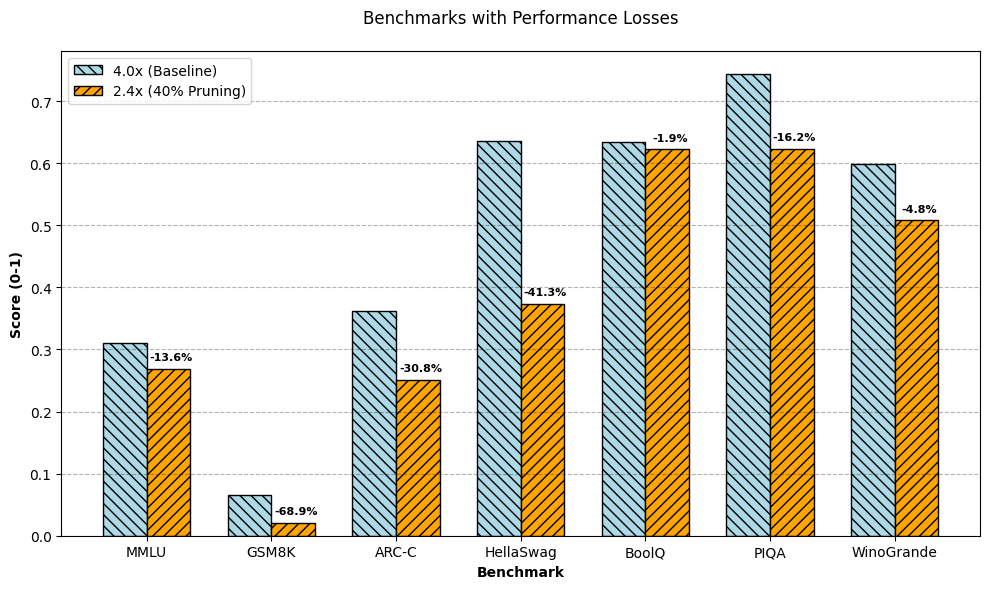

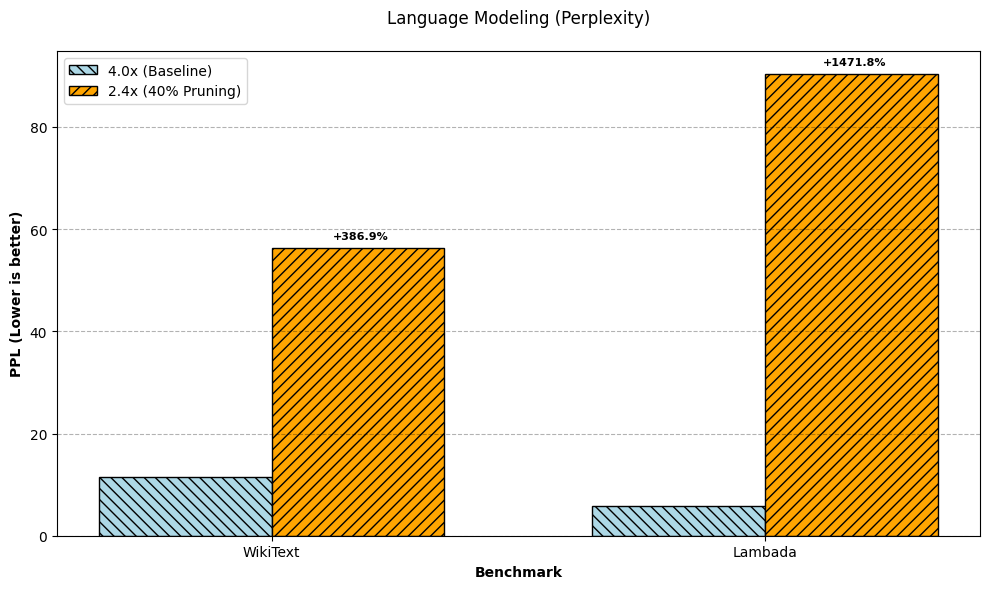

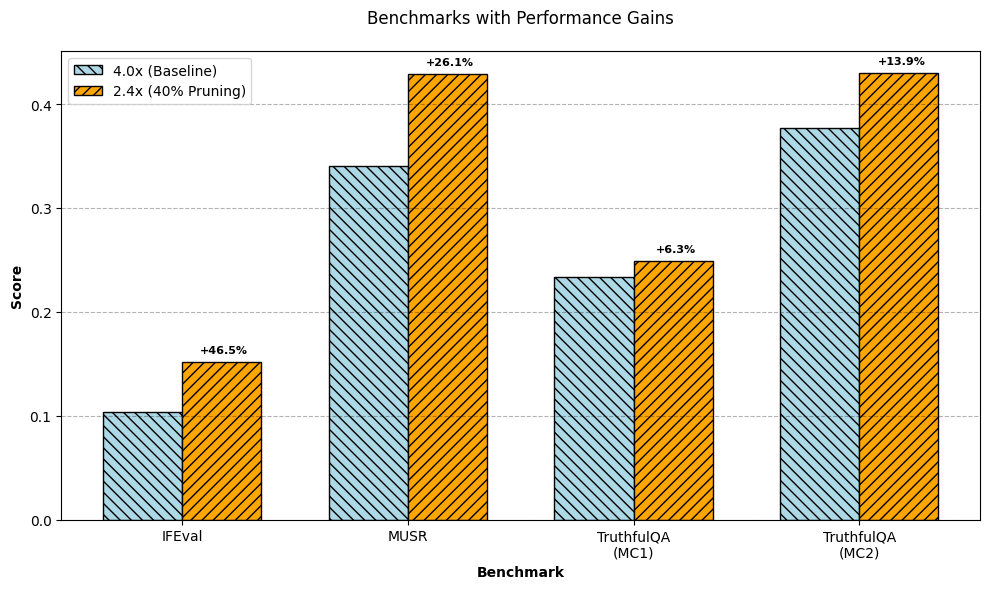

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration for Black & White Printing (Updated) ---
# Using specific patterns and colors as requested
base_color = 'lightblue'
base_edge = 'black'
base_hatch = '\\\\\\'

pruned_color = 'orange'
pruned_edge = 'black'
pruned_hatch = '///'

bar_width = 0.35
opacity = 1.0

def plot_benchmarks_bw(ax, labels, baseline_data, pruned_data, diff_labels, title, ylabel):
    """
    Helper function to plot grouped bar charts with B&W styling.
    """
    index = np.arange(len(labels))

    # Plot Baseline Bars
    rects1 = ax.bar(index, baseline_data, bar_width,
                    alpha=opacity,
                    color=base_color,
                    edgecolor=base_edge,
                    hatch=base_hatch,
                    label='4.0x (Baseline)')

    # Plot Pruned Bars
    rects2 = ax.bar(index + bar_width, pruned_data, bar_width,
                    alpha=opacity,
                    color=pruned_color,
                    edgecolor=pruned_edge,
                    hatch=pruned_hatch,
                    label='2.4x (40% Pruning)')

    # Styling
    ax.set_xlabel('Benchmark', fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, pad=20, fontsize=12)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels, rotation=0) # Rotation 0 since we have space now
    ax.legend(loc='best')
    ax.legend(loc='upper left')

    # Add simple grid
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='black')

    # Add Annotations (Only % diff on pruned bars)
    for rect, diff_label in zip(rects2, diff_labels):
        height = rect.get_height()
        ax.annotate(diff_label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(2, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8,
                    fontweight='bold',
                    color='black')

# --- Data Preparation ---

# 1. General Benchmarks Data (Accuracy)
labels_acc = ['MMLU', 'GSM8K', 'ARC-C', 'HellaSwag', 'BoolQ', 'PIQA', 'WinoGrande']
base_acc = [0.3111, 0.0660, 0.3626, 0.6363, 0.6343, 0.7437, 0.5991]
pruned_acc = [0.2689, 0.0205, 0.2509, 0.3737, 0.622, 0.6235, 0.5076]
diff_acc = ['-13.6%', '-68.9%', '-30.8%', '-41.3%', '-1.9%', '-16.2%', '-4.8%']

# 2. Perplexity Data
labels_ppl = ['WikiText', 'Lambada']
base_ppl = [11.57, 5.75]
pruned_ppl = [56.33, 90.38]
diff_ppl = ['+386.9%', '+1471.8%']

# 3. Improved Benchmarks Data
labels_imp = ['IFEval', 'MUSR', 'TruthfulQA\n(MC1)', 'TruthfulQA\n(MC2)']
base_imp = [0.1035, 0.3399, 0.2338, 0.3772]
pruned_imp = [0.1516, 0.4286, 0.2485, 0.4298]
diff_imp = ['+46.5%', '+26.1%', '+6.3%', '+13.9%']

# --- Plotting (3 Separate Figures for vertical layout) ---

# Chart 1: General Accuracy
fig1, ax1 = plt.subplots(figsize=(10, 6))
plot_benchmarks_bw(ax1, labels_acc, base_acc, pruned_acc, diff_acc,
                   'Benchmarks with Performance Losses', 'Score (0-1)')
plt.tight_layout()
plt.show()

# Chart 2: Perplexity
fig2, ax2 = plt.subplots(figsize=(10, 6))
plot_benchmarks_bw(ax2, labels_ppl, base_ppl, pruned_ppl, diff_ppl,
                   'Language Modeling (Perplexity)', 'PPL (Lower is better)')
plt.tight_layout()
plt.show()

# Chart 3: Improvements
fig3, ax3 = plt.subplots(figsize=(10, 6))
plot_benchmarks_bw(ax3, labels_imp, base_imp, pruned_imp, diff_imp,
                   'Benchmarks with Performance Gains', 'Score')
plt.tight_layout()
plt.show()

# Summary

As you can see the generated model is a totally different model from the original, the effect that pruning has had on the different benchmarks has been uneven.

The 'width-pruning' of 40% in the MLP expansion layers severely degrades the model's core capabilities. The reasoning metrics (GSM8K -68.9%), general knowledge (MMLU -13.6%), and common sense (HellaSwag -41.3%) suffer drastic drops. The most evident damage is seen in perplexity (PPL), which increases astronomically (+386.9% and +1471.8%), **indicating that the model's fundamental ability to model language and coherently predict text collapses**.

However, this pruning reveals a surprising specialization. Although the model becomes less 'intelligent' in general terms, **it improves drastically in its ability to follow instructions (IFEval +46.5%), or MUSR + 45%, and in its truthfulness (TruthfulQA +13.9% on MC2)**.

This suggests a clear 'trade-off': **the pruned model loses sophistication and world knowledge, but becomes more literal, obedient**, and less prone to hallucinating or deviating from the instruction, which improves its performance on tasks requiring strict fidelity.